# Portfolio Exercise 2 - Binary Classification: Transformer Models



# **Financial Sentiment Analysis - Binary Classification**

Financial sentiment analysis is crucial for understanding market trends and guiding investment decisions. This assignment focuses on **fine-tuning a transformer model** to classify financial text into **Positive or Negative sentiment** using the **Financial PhraseBank** dataset.

**Binary Classification** – Distinguishing between **Positive** and **Negative** sentiment in financial statements.

Using **FinBERT**, we will train and evaluate models to enhance sentiment detection in financial news and reports. This project provides hands-on experience in **deep learning and NLP** for real-world financial applications.


## **1. Dataset Selection and Preprocessing**
- Choose a dataset appropriate for your chosen classification task (**binary, multi-class, or multi-label**).
- Preprocess the data as needed (**tokenization, handling class imbalance, etc.**).


### 1.1 Install and Import Dependencies

In [4]:
!pip install transformers datasets torch scikit-learn accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils import resample

### 1.2 Load and Preprocess the Dataset

In [14]:
# Load Financial PhraseBank Dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
df = pd.DataFrame(dataset["train"])
print(df.info())  # Check for missing values and data types
print(df["label"].value_counts())  # Check class distribution
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2264 non-null   object
 1   label     2264 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.5+ KB
None
label
1    1391
2     570
0     303
Name: count, dtype: int64
                                            sentence  label
0  According to Gran , the company has no plans t...      1
1  For the last quarter of 2010 , Componenta 's n...      2
2  In the third quarter of 2010 , net sales incre...      2
3  Operating profit rose to EUR 13.1 mn from EUR ...      2
4  Operating profit totalled EUR 21.1 mn , up fro...      2


<ipython-input-7-1ed709645c17>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary["label"] = df_binary["label"].replace({2: 1})  # Convert Positive (2) → 1


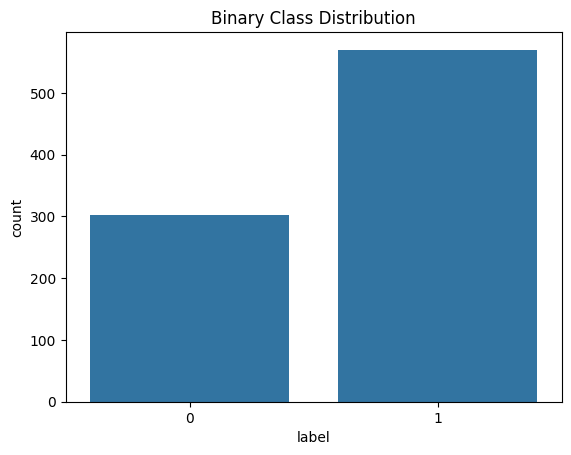

In [7]:
#  Filter for Binary Classification (Positive vs. Negative)
# Keep only Positive (2) and Negative (0) labels
df_binary = df[df["label"] != 1]  # Remove Neutral (1)
df_binary["label"] = df_binary["label"].replace({2: 1})  # Convert Positive (2) → 1

# Plot new class distribution
sns.countplot(x=df_binary["label"])
plt.title("Binary Class Distribution")
plt.show()

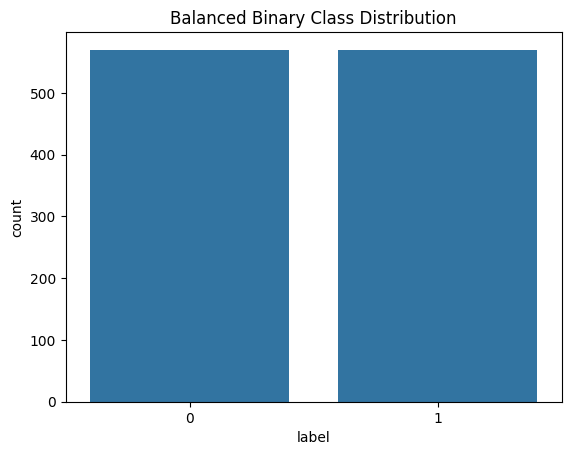

In [8]:
# Separate classes
df_majority = df_binary[df_binary["label"] == 1]  # Majority class (positive)
df_minority = df_binary[df_binary["label"] == 0]  # Minority class (negative)

# Oversample minority class to match majority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

# Combine classes
df_binary_balanced = pd.concat([df_majority, df_minority_upsampled])

# Shuffle dataset
df_binary_balanced = df_binary_balanced.sample(frac=1, random_state=42)

# Check new class distribution
sns.countplot(x=df_binary_balanced["label"])
plt.title("Balanced Binary Class Distribution")
plt.show()


In [9]:
# Step 3: Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_binary["sentence"].tolist(), df_binary["label"].tolist(), test_size=0.2, random_state=42
)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({"sentence": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"sentence": val_texts, "label": val_labels})


## **2. Model Selection and Fine-Tuning**
- Use a **transformer model** (e.g., **BERT, RoBERTa, DistilBERT**) from Hugging Face.
- Fine-tune the model on your selected dataset using libraries such as **Simple Transformers** or **Hugging Face Transformers**.
- Document your training process, including:
  - Hyperparameter choices  
  - Evaluation metrics  
  - Challenges encountered  



### 2.1 Load Tokenizer and Tokenize Data

In [10]:
MODEL_NAME = "ProsusAI/finbert"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/698 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

### 2.2 Load Pretrained FinBERT Model

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, ignore_mismatched_sizes=True)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2.3 Define Evaluation Metrics

In [12]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)  # Convert logits to predicted class
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall} #, "ROC-AUC": ROC-AUC


### 2.4 Define Training Arguments

In [13]:
training_args = TrainingArguments(
    output_dir="./finbert-binary-results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### 2.5 Train the Model



In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.128300,0.181824,0.948571,0.948772,0.949551,0.948571
2,0.007600,0.139382,0.971429,0.971387,0.971413,0.971429
3,0.002400,0.137348,0.971429,0.971387,0.971413,0.971429


TrainOutput(global_step=264, training_loss=0.07995917392316076, metrics={'train_runtime': 62.5356, 'train_samples_per_second': 33.485, 'train_steps_per_second': 4.222, 'total_flos': 137738637480960.0, 'train_loss': 0.07995917392316076, 'epoch': 3.0})

## **3. Evaluation**
- Evaluate your fine-tuned model using appropriate metrics:
  - **Binary Classification**: Accuracy, F1-score, ROC-AUC  
  - **Multi-Class / Multi-Label**: Precision, Recall, F1-score  
- Provide a **brief analysis** of the model’s performance on the test set.



### 3.1 Evaluate Model Performance

In [ ]:
# Evaluate on validation set
results = trainer.evaluate()
print("Evaluation Metrics:", results)


Evaluation Metrics: {'eval_loss': 0.13734808564186096, 'eval_accuracy': 0.9714285714285714, 'eval_f1': 0.9713869928276914, 'eval_precision': 0.9714126851741532, 'eval_recall': 0.9714285714285714, 'eval_runtime': 1.266, 'eval_samples_per_second': 138.227, 'eval_steps_per_second': 17.377, 'epoch': 3.0}


### 3.2 Compare Training and Validation *Accuracy*

In [ ]:
train_results = trainer.evaluate(train_dataset)
print("Training Metrics:", train_results)


Training Metrics: {'eval_loss': 0.012243800796568394, 'eval_accuracy': 0.995702005730659, 'eval_f1': 0.9957042207907297, 'eval_precision': 0.9957109879959434, 'eval_recall': 0.995702005730659, 'eval_runtime': 4.7409, 'eval_samples_per_second': 147.23, 'eval_steps_per_second': 18.562, 'epoch': 3.0}


### 3.3 Confusion metrix

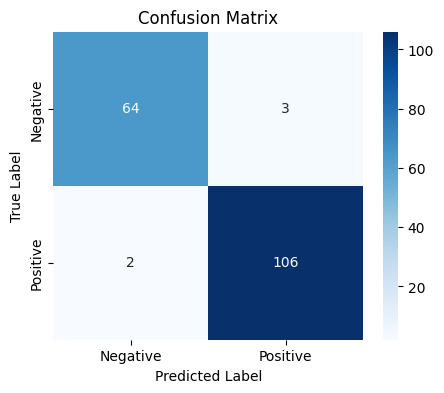

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get model predictions
predictions = trainer.predict(val_dataset).predictions
predictions = predictions.argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(val_labels, predictions)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


---

# **🔍 Model Evaluation Summary**

## **1️⃣ Confusion Matrix Analysis**
- **True Negatives (64)** → Correctly predicted negative cases  
- **False Positives (3)** → Incorrectly classified as positive (false alarm)  
- **False Negatives (2)** → Incorrectly classified as negative (missed positive)  
- **True Positives (106)** → Correctly predicted positive cases  

✅ **Low misclassification rate** with minimal false positives and false negatives.

---

## **2️⃣ Training vs. Validation Performance**
| **Metric**   | **Training Set** | **Validation Set** |
|-------------|-----------------|--------------------|
| **Accuracy**  | 99.57% | 97.14% |
| **F1-Score**  | 99.57% | 97.13% |
| **Precision** | 99.57% | 97.14% |
| **Recall**    | 99.57% | 97.14% |

✅ **No major overfitting** detected – training and validation scores are well-aligned.  
✅ **Model is generalizing well** to unseen data.

---

## **🚀 Next Steps**
- **Proceed to Deployment (Streamlit/Gradio)** ✅  
- **Fine-tune further** (if needed) by adjusting epochs or dropout rates 🔧  

---

## **4. Deployment (Optional)**
- Optionally, develop a **simple web application** using **Streamlit** or **Gradio**.
- The app should allow users to **input text and see classification predictions**.
- This step demonstrates how your model can be used in a **real-world application**.



In [ ]:
# the application can be found in hugging face link:

## **5. Upload to Hugging Face Hub**
- Once fine-tuning is complete, upload your model to the **Hugging Face Hub**.
- Provide a **repository link** and ensure your **model card** includes:
  - Dataset details  
  - Training parameters  
  - Evaluation metrics  
  - Intended use  

In [ ]:
# the Model can be found in hugging face link: